In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_triplicated_data_for_time_alignment(df, alignment_col):
    """

    """

    rel_points = df[df[alignment_col] > 0].reset_index()
    # print(rel_points)

    identifiers = rel_points[['index', 'nTrial', 'nEndTrial']].dropna().values.astype(int)
    if len(identifiers) == 0:
        return pd.DataFrame(columns=df.reset_index().columns)

    # print('identifiers')
    # print(identifiers)
    

    lst_extendeds = []
    
    for idx, nTrial, nEndTrial in identifiers:
        extended_trial = df[(df['nTrial'] == nTrial) | (df['nEndTrial'] == nEndTrial)].reset_index().copy()
        extended_trial['index'] -= idx

        # print('extended_trial')
        # print(extended_trial)

        lst_extendeds.append(extended_trial.copy())
        
    relative_df = pd.concat(lst_extendeds)
    return relative_df

In [3]:
df = pd.read_csv('/Users/josh/Desktop/investigation/fig2-single-individ-ft_WT63_11082021_best_resids_R2_0.5419.csv')

In [4]:
df['photometrySideInIndex'] = df['photometrySideInIndexr'] + df['photometrySideInIndexnr']
df['nEndTrial'] = np.nan
df.loc[df['wi_trial_keep'] == False, 'nEndTrial'] = df.loc[df['wi_trial_keep'] == False, 'nTrial']
df.loc[df['wi_trial_keep'] == True, 'nEndTrial'] = df.loc[df['wi_trial_keep'] == True, 'nTrial'] - 1
rl_df = get_triplicated_data_for_time_alignment(df, 'photometrySideInIndex')

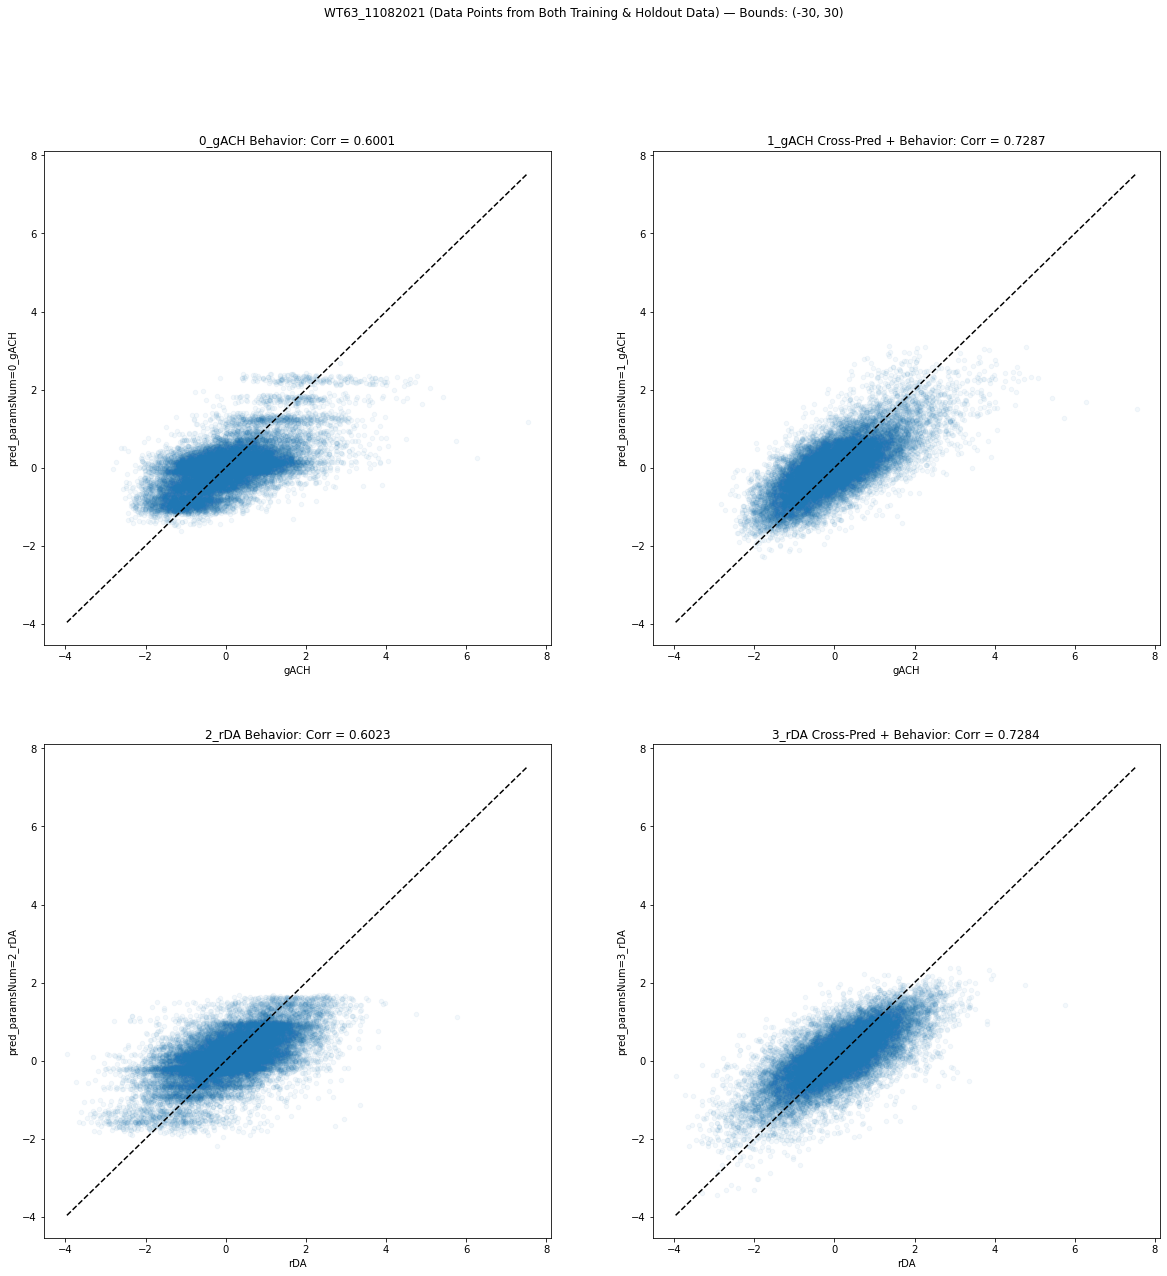

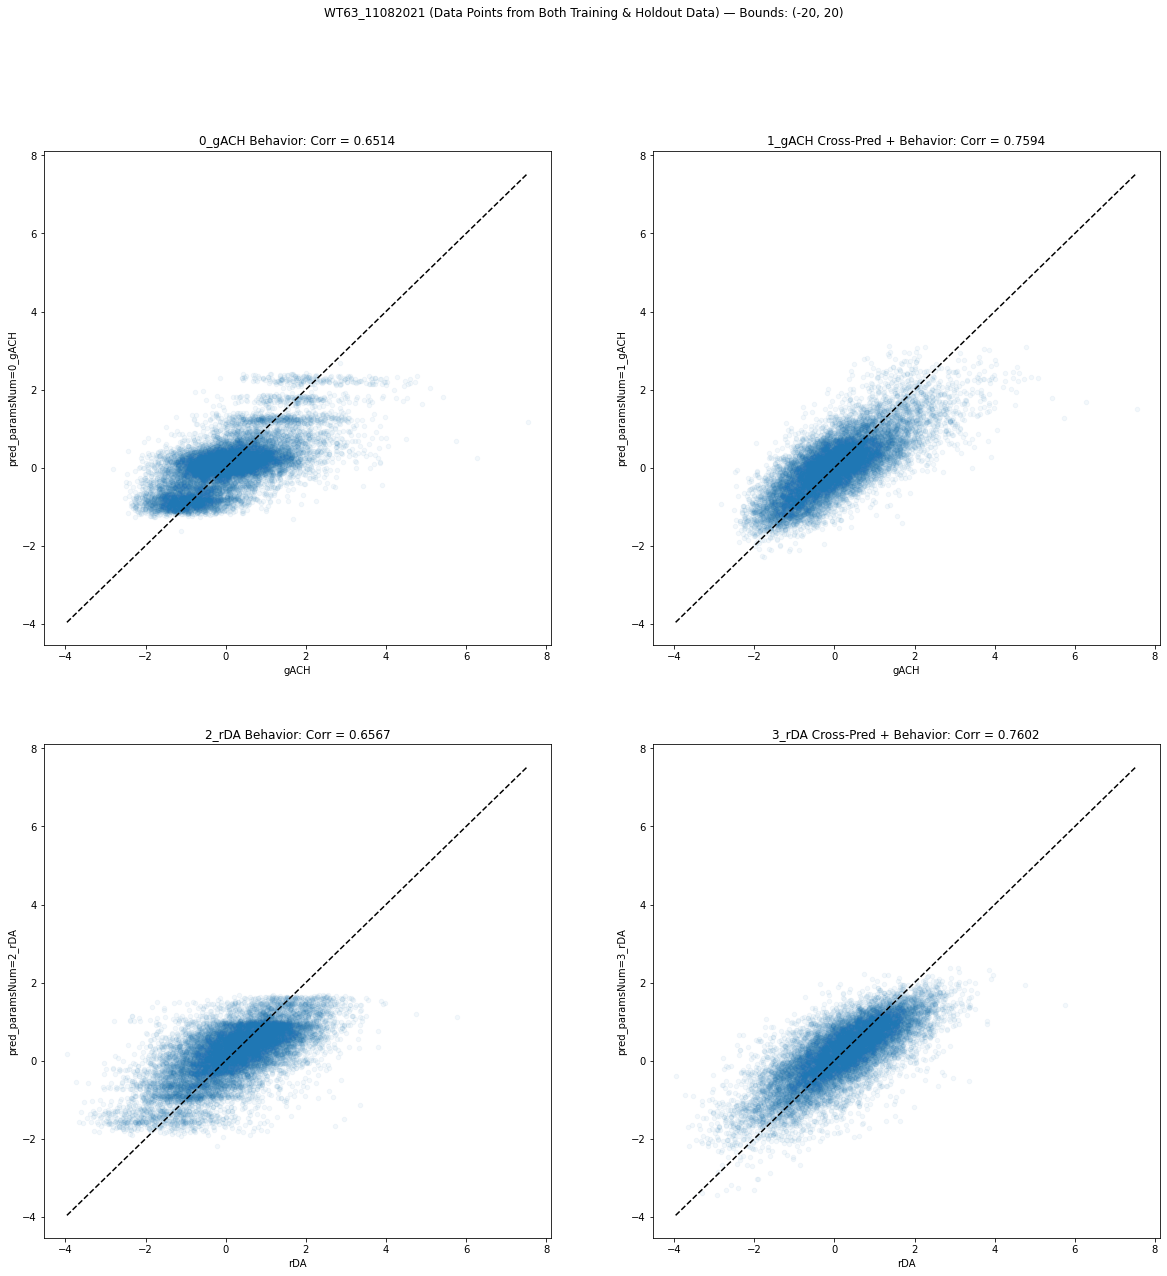

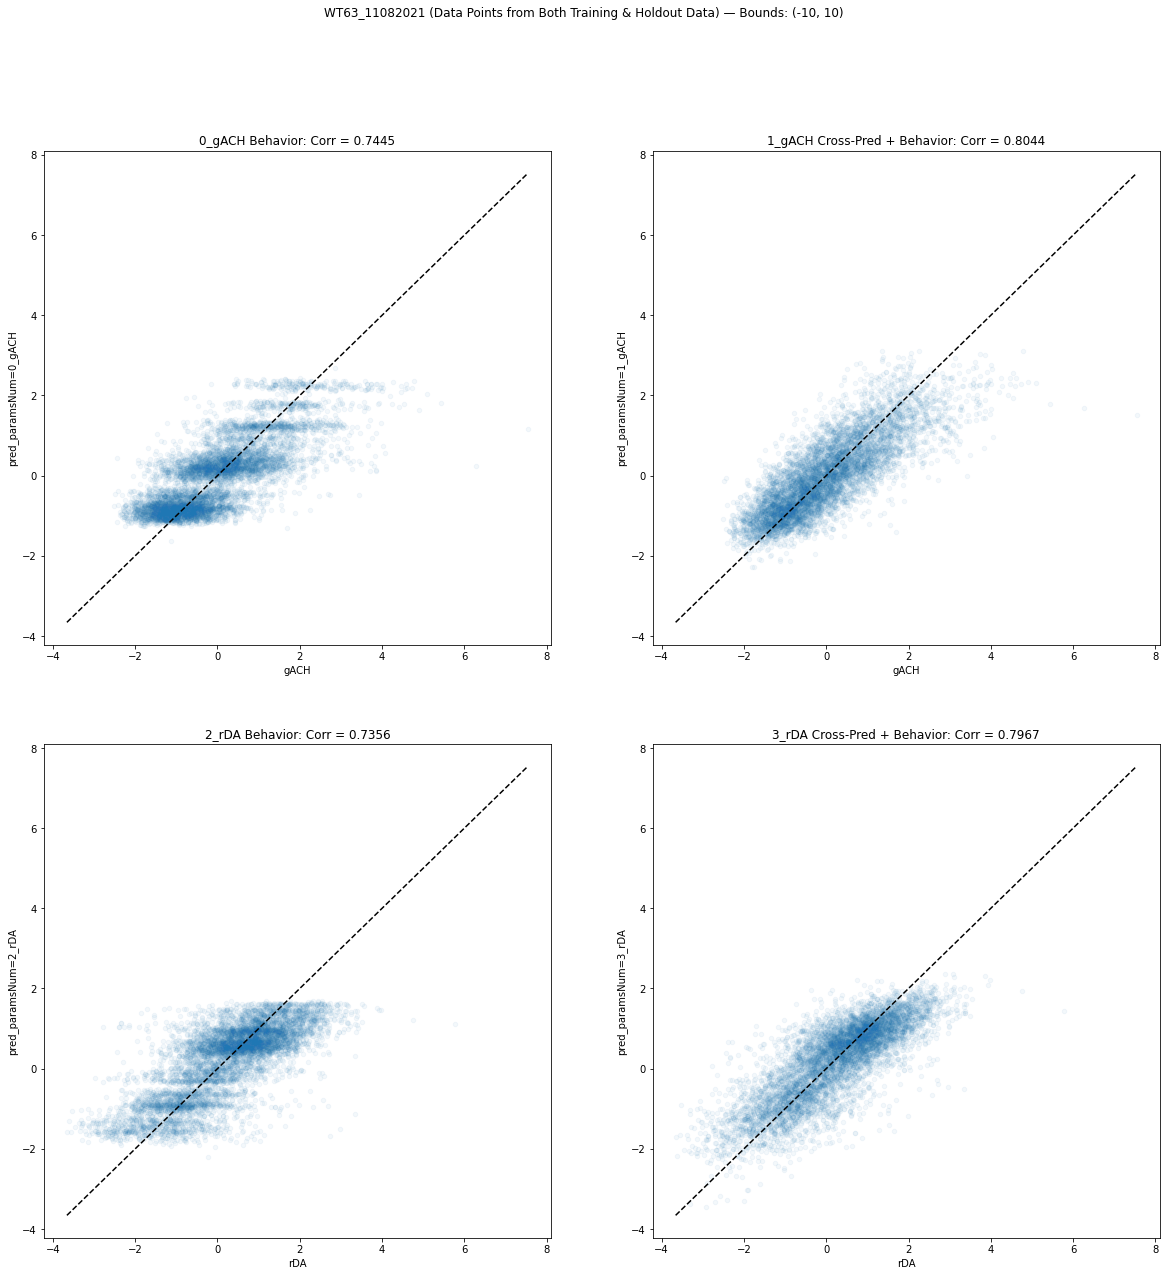

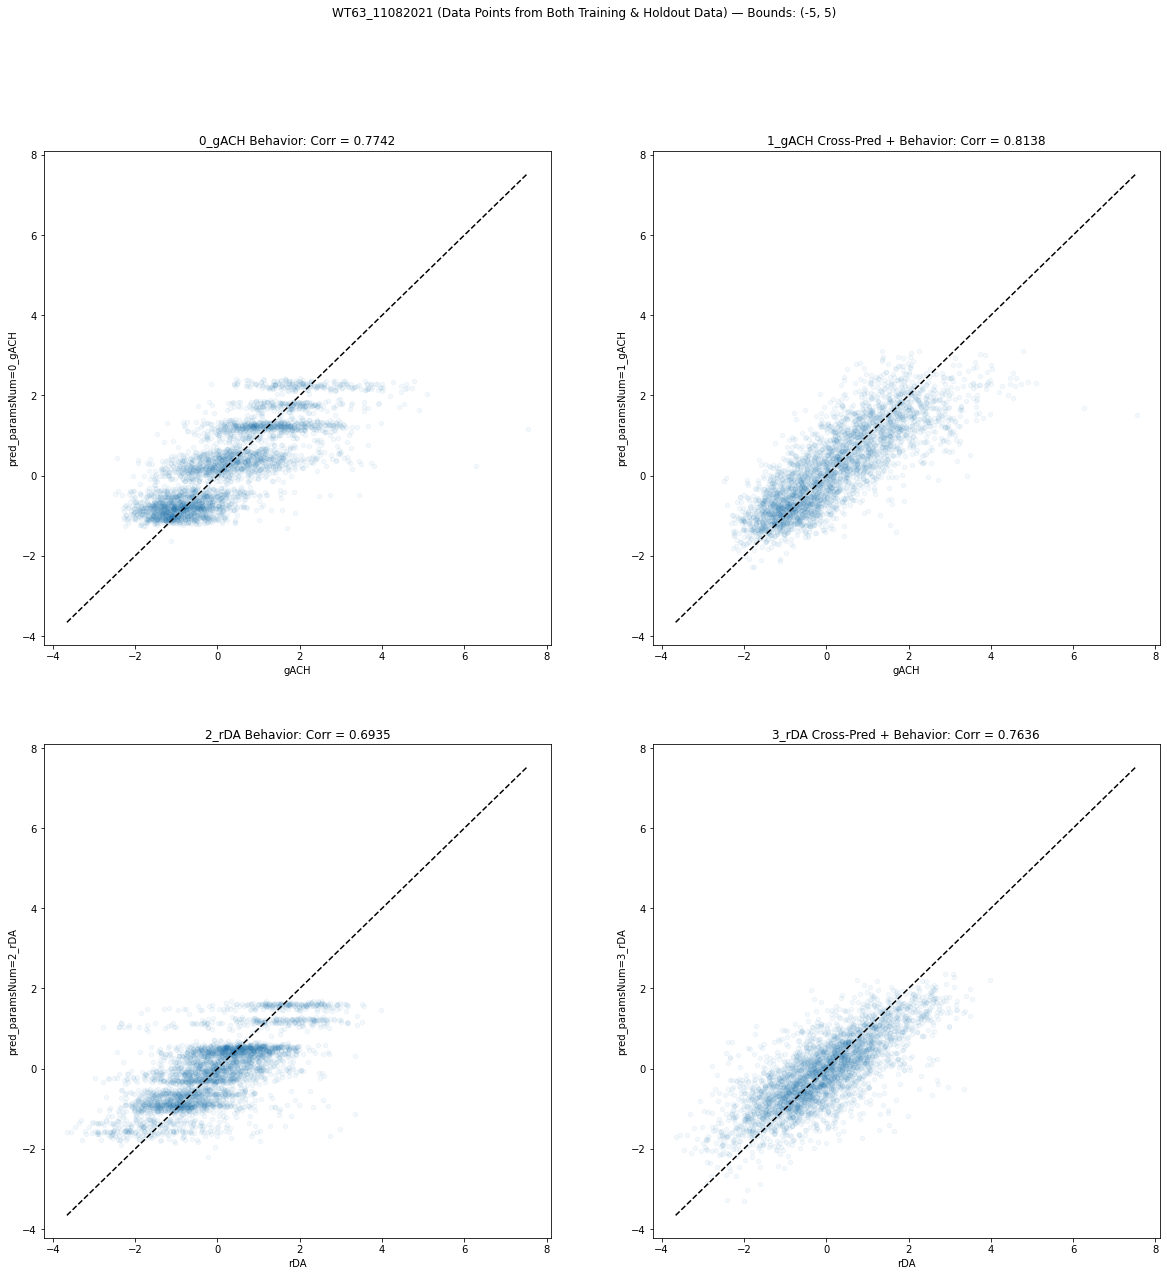

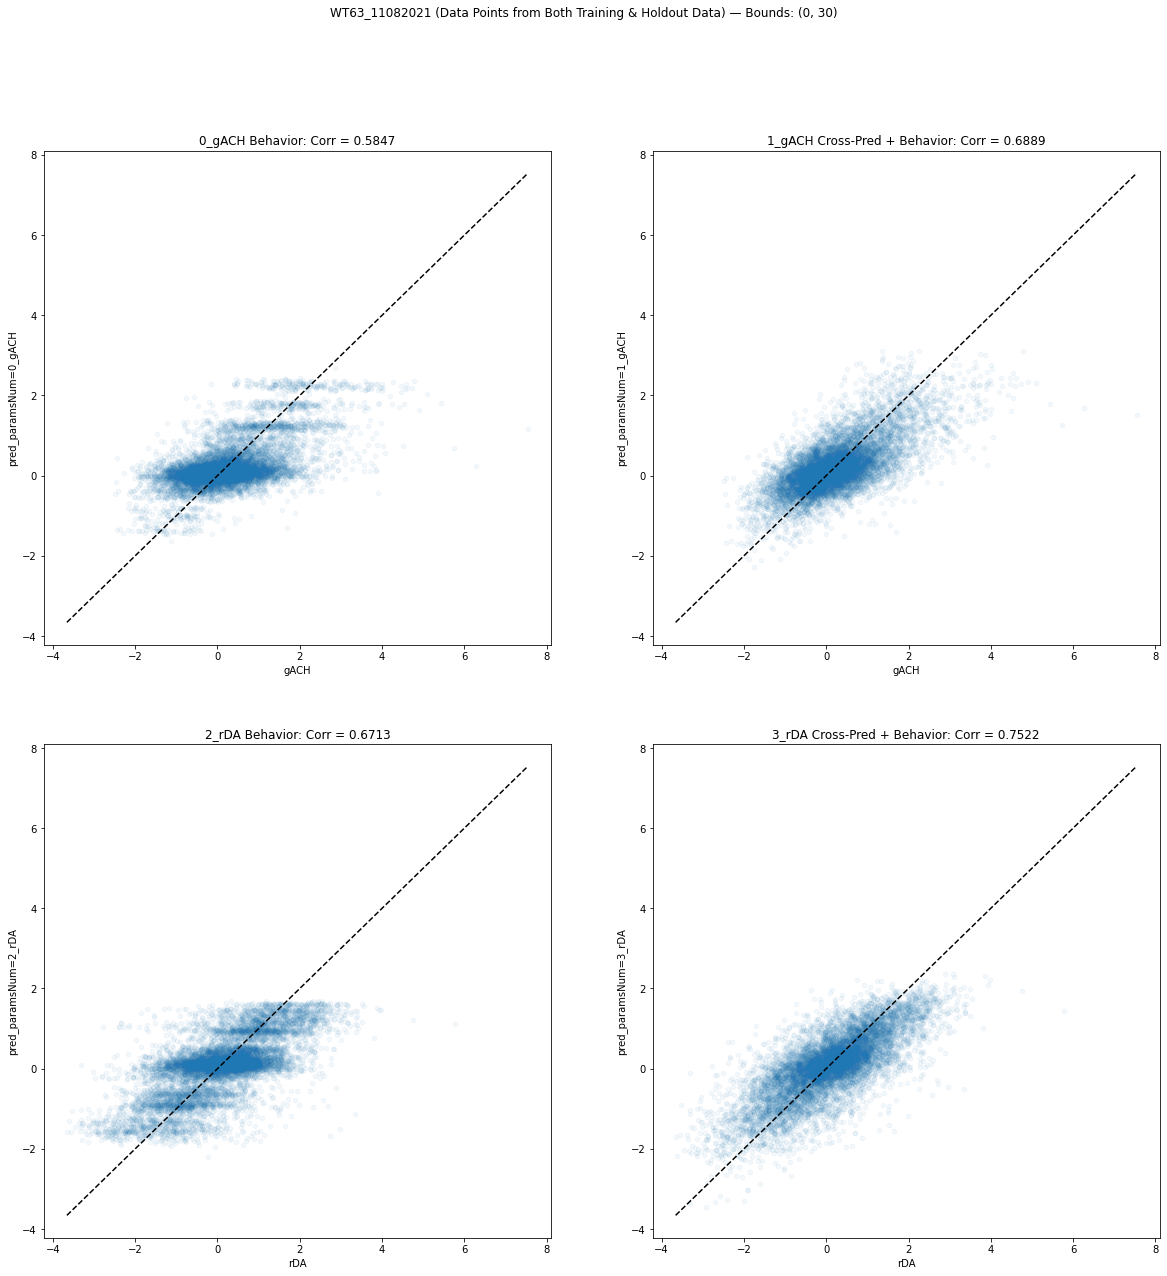

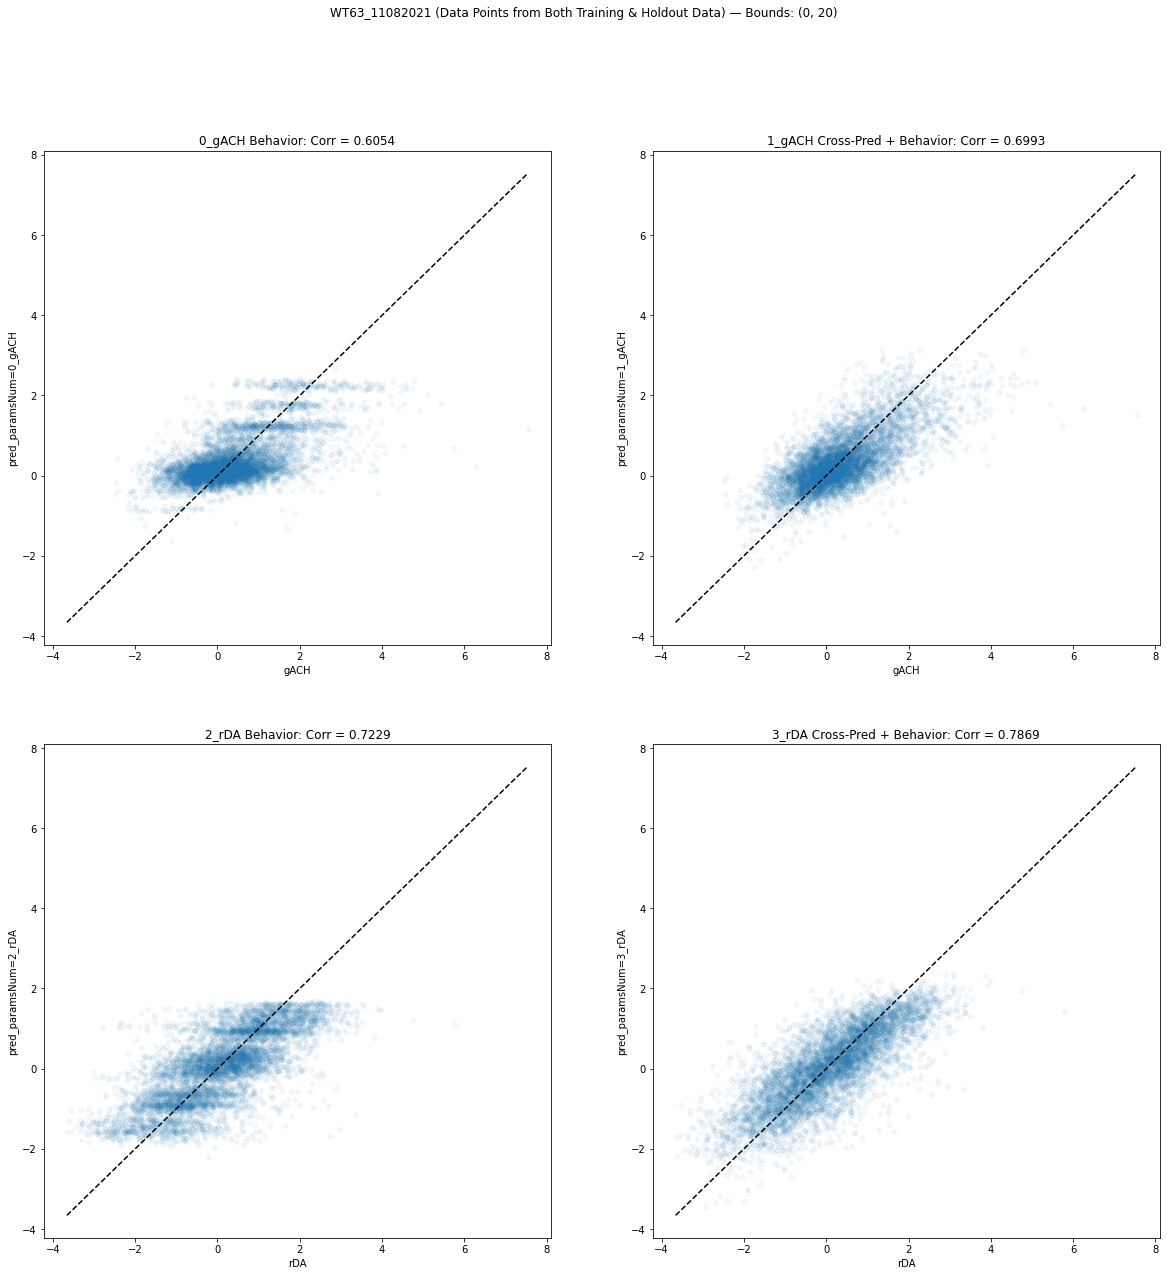

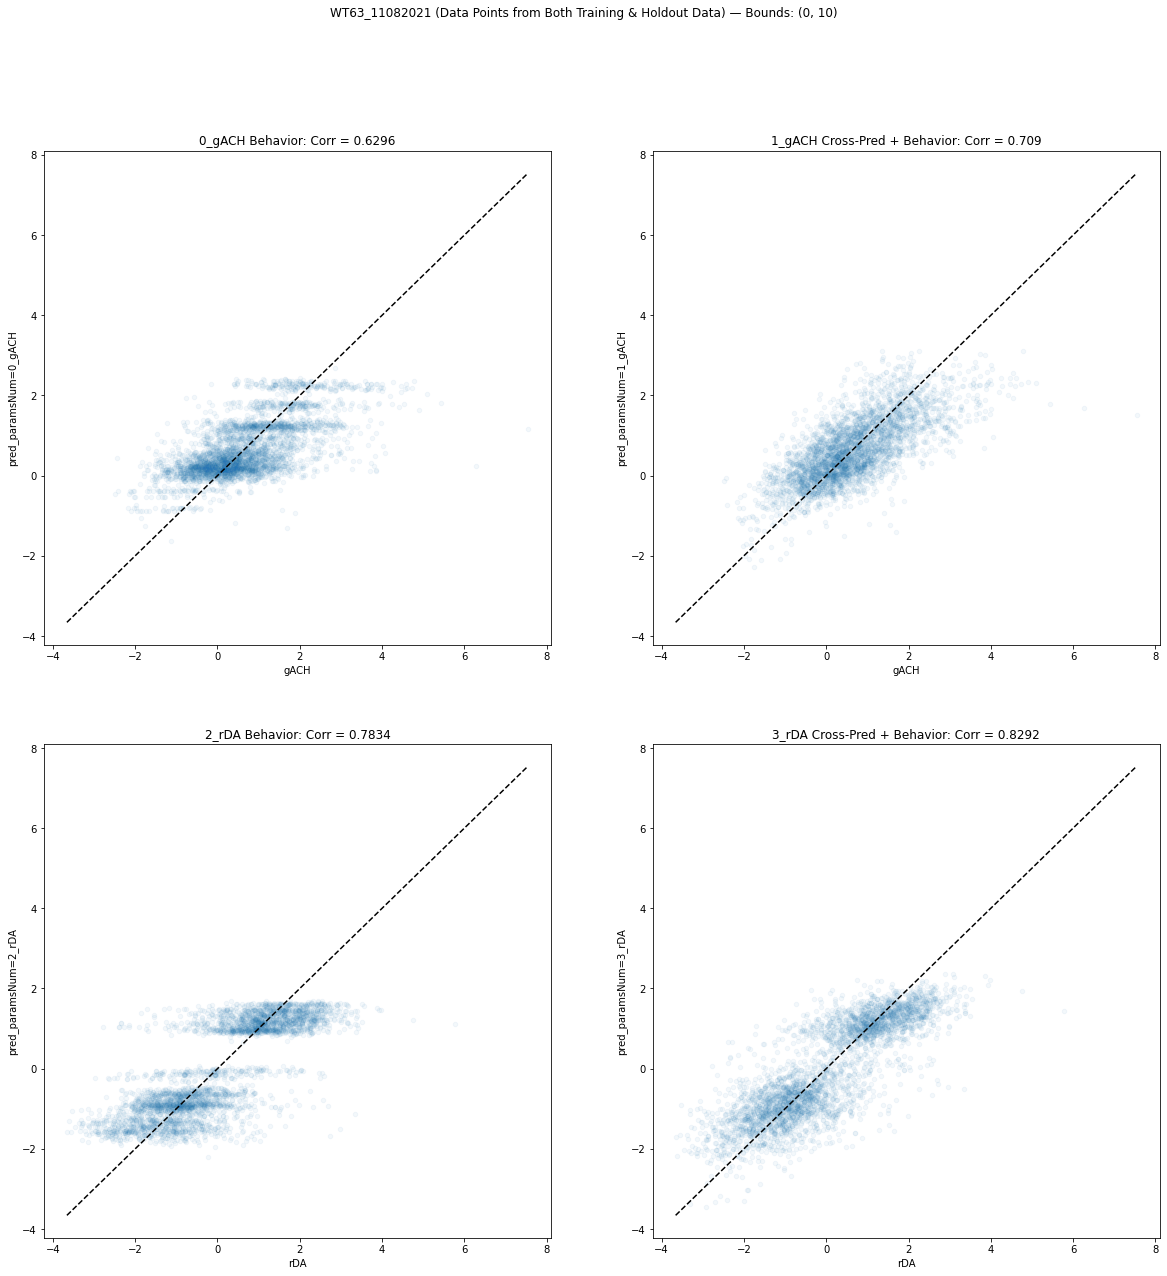

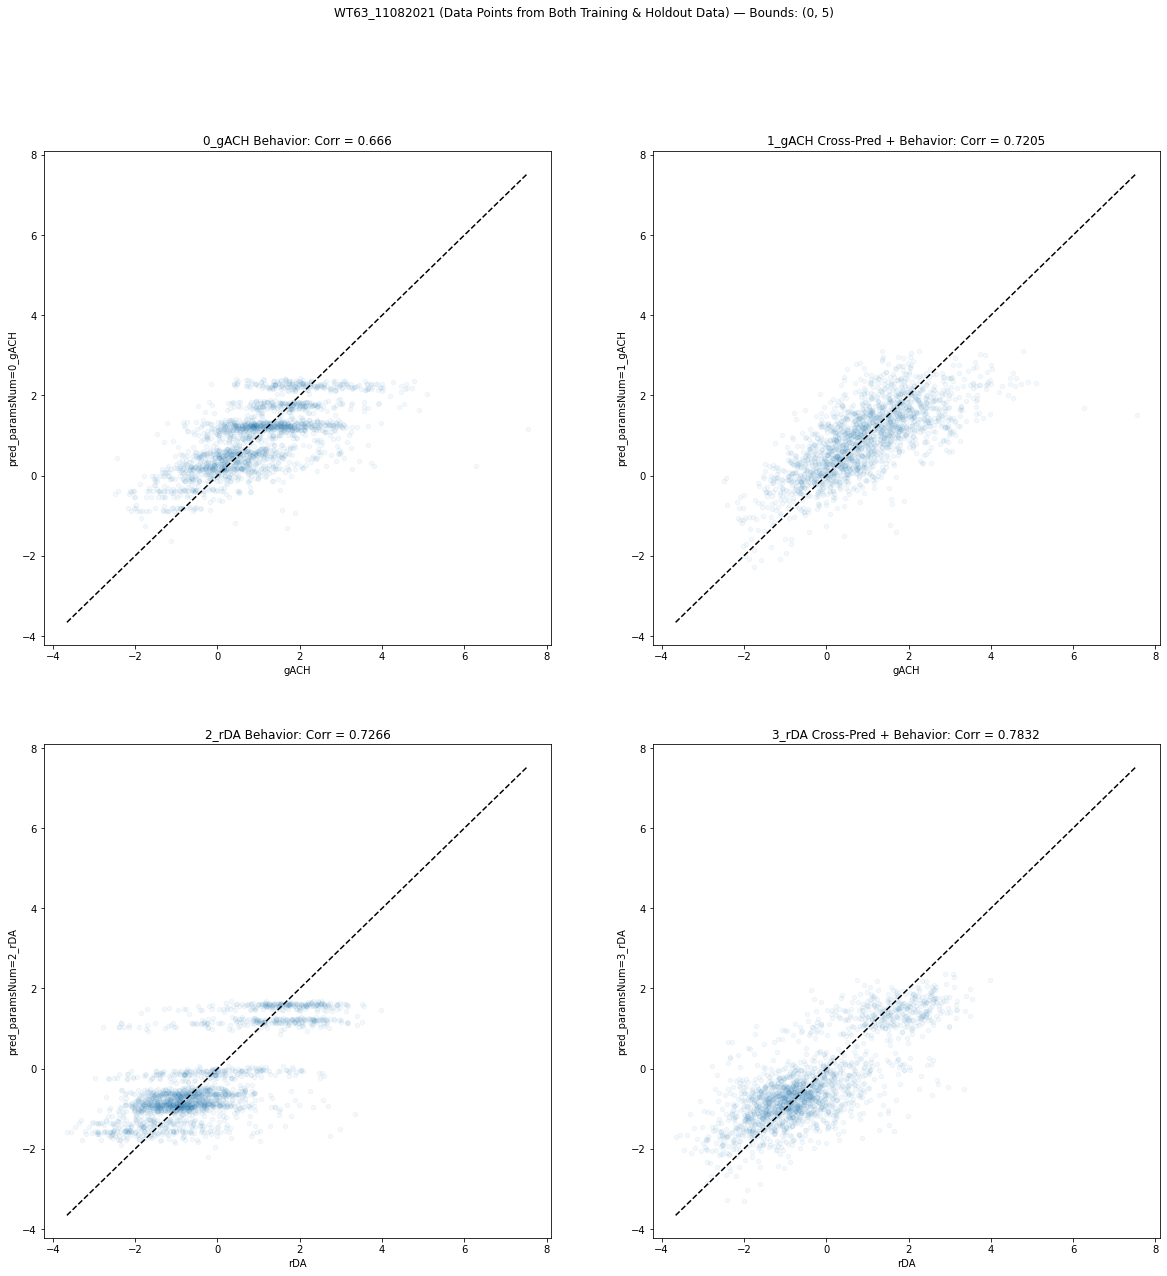

In [5]:
for bounds in [[-30, 30], [-20, 20], [-10, 10], [-5, 5],
               [0, 30], [0, 20], [0, 10], [0, 5],
              ]:
    pairwise = rl_df[rl_df['index'].between(bounds[0], bounds[1])][['index', 'gDA', 'gACH', 'rDA',
                                                                    'pred_paramsNum=0_gACH', 'pred_paramsNum=1_gACH',
                                                                    'pred_paramsNum=2_rDA', 'pred_paramsNum=3_rDA']]
    pairs = [
            ['gACH', 'pred_paramsNum=0_gACH'],
            ['gACH', 'pred_paramsNum=1_gACH'],
            ['rDA', 'pred_paramsNum=2_rDA'],
            ['rDA', 'pred_paramsNum=3_rDA'],
        ]

    bound_min = np.inf
    bound_max = -np.inf
    for pair_cols in pairs:
        x, y = pair_cols[0], pair_cols[1]
        min_val = min(np.min(pairwise[x]), np.min(pairwise[y]))
        max_val = max(np.max(pairwise[x]), np.max(pairwise[y]))

        if min_val < bound_min:
            bound_min = min_val
        if max_val > bound_max:
            bound_max = max_val

    basis_line = np.linspace(bound_min, bound_max)

    fig, ax = plt.subplots(2,2,figsize=(20,20), facecolor='white')
    fig.suptitle(f'WT63_11082021 (Data Points from Both Training & Holdout Data) — Bounds: ({bounds[0]}, {bounds[1]})')
    for ip, pair_cols in enumerate(pairs):
        tmp_ax = ax[ip//2, ip%2]

        x, y = pair_cols[0], pair_cols[1]

        tmp_pair = pairwise[pair_cols].copy()
        corr = np.round(tmp_pair.corr().iloc[0,1], 4)
        
        info = y.split('=')[-1]
        if int(info[0]) % 2 == 1:
            info += ' Cross-Pred + Behavior'
        else:
            info += ' Behavior'

        tmp_pair.plot.scatter(x, y, alpha=0.05, ax=tmp_ax)
        tmp_ax.plot(basis_line, basis_line, c='k', linestyle='--')
        tmp_ax.set_title(f'{info}: Corr = {corr}')
    fig.savefig(f'/Users/josh/Desktop/investigation/corr_analysis_WT63_11082021_bnd={bounds[0]}_{bounds[1]}.png')

In [13]:
X_cols_dict = {

    'photometryCenterInIndex':(-20,20), #'photometryCenterOutIndex':(0,0),
    # 'sl': (0,0),
    'photometrySideInIndexr':(-20,20), 'photometrySideInIndexnr':(-20,20),
    
    # 'photometrySideInIndexAA':(0,0), 'photometrySideInIndexAa':(0,0),
    # 'photometrySideInIndexaA':(0,0), 'photometrySideInIndexaa':(0,0),
    # 'photometrySideInIndexAB':(0,0), 'photometrySideInIndexAb':(0,0),
    # 'photometrySideInIndexaB':(0,0), 'photometrySideInIndexab':(0,0),

    'photometrySideOutIndex':(-20,20),
    'spnnrOff': (-20,20),
    # 'slOff': (0,0),
    # 'rDA': (-20,20),
}

In [23]:
from sglm.features import setup_model_fit as smf

for bounds in [#[-30, 30], [-20, 20], [-10, 10], [-5, 5],
               #[0, 30], [0, 20], [0, 10], [0, 5],
               [-5, 5]
              ]:
    pairwise = rl_df[rl_df['index'].between(bounds[0], bounds[1])]
    tmp_signal_df, X_cols_sftd = smf.timeshift_vals_by_dict(pairwise, X_cols_dict)
    disp = tmp_signal_df.groupby(X_cols_sftd).count()
    break
with pd.option_context('display.max_rows', 5000):
    display(disp.sort_values('spnnrOff', ascending=False).head())

level_0  \
photometryCenterInIndex_-20 photometryCenterInIndex_-19 photometryCenterInIndex_-18 photometryCenterInIndex_-17 photometryCenterInIndex_-16 photometryCenterInIndex_-15 photometryCenterInIndex_-14 photometryCenterInIndex_-13 photometryCenterInIndex_-12 photometryCenterInIndex_-11 photometryCenterInIndex_-10 photometryCenterInIndex_-9 photometryCenterInIndex_-8 photometryCenterInIndex_-7 photometryCenterInIndex_-6 photometryCenterInIndex_-5 photometryCenterInIndex_-4 photometryCenterInIndex_-3 photometryCenterInIndex_-2 photometryCenterInIndex_-1 photometryCenterInIndex_0 photometryCenterInIndex_1 photometryCenterInIndex_2 photometryCenterInIndex_3 photometryCenterInIndex_4 photometryCenterInIndex_5 photometryCenterInIndex_6 photometryCenterInIndex_7 photometryCenterInIndex_8 photometryCenterInIndex_9 photometryCenterInIndex_10 photometryCenterInIndex_11 photometryCenterInIndex_12 photometryCenterInIndex_13 photometryCenterInIndex_14 photometryCenterInIndex_15 photometryCenterInIndex_16 photometryCenterInIndex_17 photometryCenterInIndex_18 photometryCenterInIndex_19 photometryCenterInIndex_20 photometrySideInIndexr_-20 photometrySideInIndexr_-19 photometrySideInIndexr_-18 photometrySideInIndexr_-17 photometrySideInIndexr_-16 photometrySideInIndexr_-15 photometrySideInIndexr_-14 photometrySideInIndexr_-13 photometrySideInIndexr_-12 photometrySideInIndexr_-11 photometrySideInIndexr_-10 photometrySideInIndexr_-9 photometrySideInIndexr_-8 photometrySideInIndexr_-7 photometrySideInIndexr_-6 photometrySideInIndexr_-5 photometrySideInIndexr_-4 photometrySideInIndexr_-3 photometrySideInIndexr_-2 photometrySideInIndexr_-1 photometrySideInIndexr_0 photometrySideInIndexr_1 photometrySideInIndexr_2 photometrySideInIndexr_3 photometrySideInIndexr_4 photometrySideInIndexr_5 photometrySideInIndexr_6 photometrySideInIndexr_7 photometrySideInIndexr_8 photometrySideInIndexr_9 photometrySideInIndexr_10 photometrySideInIndexr_11 photometrySideInIndexr_12 photometrySideInIndexr_13 photometrySideInIndexr_14 photometrySideInIndexr_15 photometrySideInIndexr_16 photometrySideInIndexr_17 photometrySideInIndexr_18 photometrySideInIndexr_19 photometrySideInIndexr_20 photometrySideInIndexnr_-20 photometrySideInIndexnr_-19 photometrySideInIndexnr_-18 photometrySideInIndexnr_-17 photometrySideInIndexnr_-16 photometrySideInIndexnr_-15 photometrySideInIndexnr_-14 photometrySideInIndexnr_-13 photometrySideInIndexnr_-12 photometrySideInIndexnr_-11 photometrySideInIndexnr_-10 photometrySideInIndexnr_-9 photometrySideInIndexnr_-8 photometrySideInIndexnr_-7 photometrySideInIndexnr_-6 photometrySideInIndexnr_-5 photometrySideInIndexnr_-4 photometrySideInIndexnr_-3 photometrySideInIndexnr_-2 photometrySideInIndexnr_-1 photometrySideInIndexnr_0 photometrySideInIndexnr_1 photometrySideInIndexnr_2 photometrySideInIndexnr_3 photometrySideInIndexnr_4 photometrySideInIndexnr_5 photometrySideInIndexnr_6 photometrySideInIndexnr_7 photometrySideInIndexnr_8 photometrySideInIndexnr_9 photometrySideInIndexnr_10 photometrySideInIndexnr_11 photometrySideInIndexnr_12 photometrySideInIndexnr_13 photometrySideInIndexnr_14 photometrySideInIndexnr_15 photometrySideInIndexnr_16 photometrySideInIndexnr_17 photometrySideInIndexnr_18 photometrySideInIndexnr_19 photometrySideInIndexnr_20 photometrySideOutIndex_-20 photometrySideOutIndex_-19 photometrySideOutIndex_-18 photometrySideOutIndex_-17 photometrySideOutIndex_-16 photometrySideOutIndex_-15 photometrySideOutIndex_-14 photometrySideOutIndex_-13 photometrySideOutIndex_-12 photometrySideOutIndex_-11 photometrySideOutIndex_-10 photometrySideOutIndex_-9 photometrySideOutIndex_-8 photometrySideOutIndex_-7 photometrySideOutIndex_-6 photometrySideOutIndex_-5 photometrySideOutIndex_-4 photometrySideOutIndex_-3 photometrySideOutIndex_-2 photometrySideOutIndex_-1 photometrySideOutIndex_0 photometrySideOutIndex_1 photometrySideOutIndex_2 photometrySideOutIndex_3 photometrySideOutIndex_4 photometrySideOutIndex_5 photometrySideOutIndex_6 

In [19]:
# sftd_cols = 
for col in ['photometryCenterInIndex','photometrySideInIndexr','photometrySideInIndexnr','photometrySideOutIndex','spnnrOff']:
    print([_ for _ in list(tmp_signal_df.columns) if col in _])

['photometryCenterInIndex', 'photometryCenterInIndex_-20', 'photometryCenterInIndex_-19', 'photometryCenterInIndex_-18', 'photometryCenterInIndex_-17', 'photometryCenterInIndex_-16', 'photometryCenterInIndex_-15', 'photometryCenterInIndex_-14', 'photometryCenterInIndex_-13', 'photometryCenterInIndex_-12', 'photometryCenterInIndex_-11', 'photometryCenterInIndex_-10', 'photometryCenterInIndex_-9', 'photometryCenterInIndex_-8', 'photometryCenterInIndex_-7', 'photometryCenterInIndex_-6', 'photometryCenterInIndex_-5', 'photometryCenterInIndex_-4', 'photometryCenterInIndex_-3', 'photometryCenterInIndex_-2', 'photometryCenterInIndex_-1', 'photometryCenterInIndex_0', 'photometryCenterInIndex_1', 'photometryCenterInIndex_2', 'photometryCenterInIndex_3', 'photometryCenterInIndex_4', 'photometryCenterInIndex_5', 'photometryCenterInIndex_6', 'photometryCenterInIndex_7', 'photometryCenterInIndex_8', 'photometryCenterInIndex_9', 'photometryCenterInIndex_10', 'photometryCenterInIndex_11', 'photometry